# Skin Cancer Detection using CNN

-----------------------------------------------
> Author : Shiva Kumar Bandaru   
> E-mail : shivamkr.b271999@gmail.com  

------------------------------------------------------------------

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/Assignment/Data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN/Assignment/Data/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
##train_ds = ##todo

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size,
                                                               image_size=(img_height, img_width), 
                                                               seed=123,   
                                                               validation_split=0.2,
                                                               subset="training",)
train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#val_ds = ##todo
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                             batch_size=batch_size,
                                                             image_size=(img_height, img_width),
                                                             seed=123,
                                                             validation_split=0.2,
                                                             subset="validation",)
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

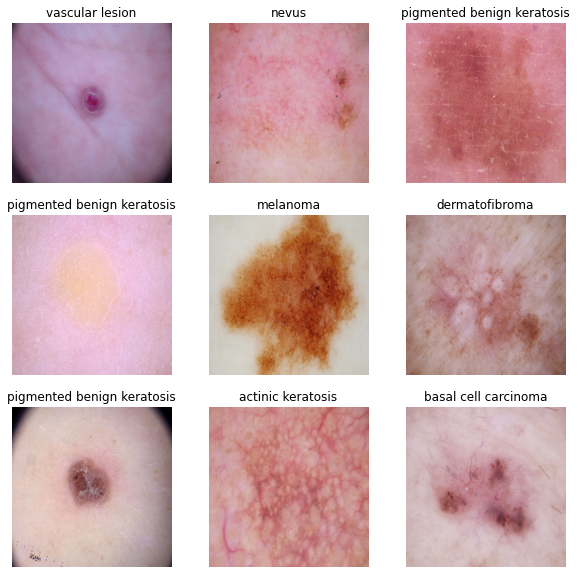

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.13660021 0.81748384


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(10, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 154s 3s/step - loss: 2.0408 - accuracy: 0.2271 - val_loss: 1.8419 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7414 - accuracy: 0.3733 - val_loss: 1.6302 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.5695 - accuracy: 0.4392 - val_loss: 1.5318 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4862 - accuracy: 0.4727 - val_loss: 1.4800 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4157 - accuracy: 0.5073 - val_loss: 1.3925 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3293 - accuracy: 0.5513 - val_loss: 1.4007 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3393 - accuracy: 0.5391 - val_loss: 1.3386 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

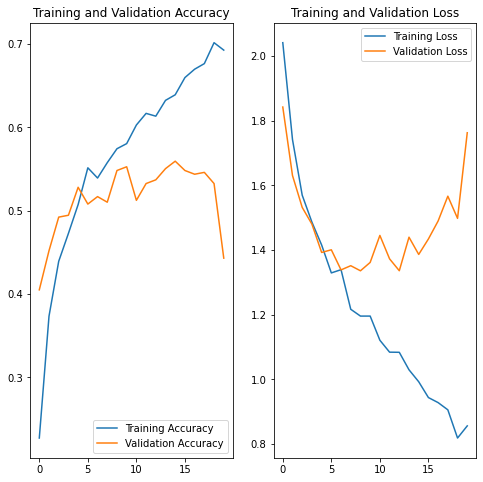

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Findings after 20 epochs
# We got Traning accuracy    - 0.8438  (84%)
# We got Validation accuracy - 0.5302  (53%)

# The plots show that training accuracy and validation accuracy are off by large margins, 
# and the model has achieved only around 50% accuracy on the validation set.

# In the plots above, the training accuracy is increasing linearly over time, 
# whereas validation accuracy stalls around 50% in the training process. Also, 
# the difference in accuracy between training and validation accuracy is noticeable—a sign of Overfitting.

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

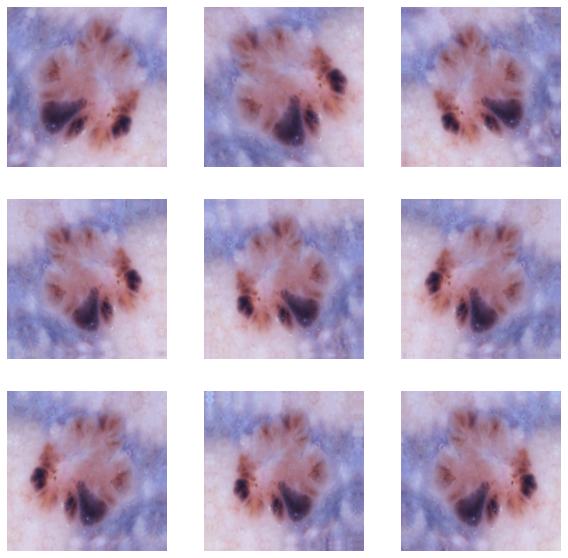

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])

### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 14s 174ms/step - loss: 2.0606 - accuracy: 0.1992 - val_loss: 2.0237 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 10s 170ms/step - loss: 1.8708 - accuracy: 0.3153 - val_loss: 1.6510 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 8s 147ms/step - loss: 1.6699 - accuracy: 0.3906 - val_loss: 1.6854 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 8s 145ms/step - loss: 1.5847 - accuracy: 0.4442 - val_loss: 1.5174 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 10s 171ms/step - loss: 1.4974 - accuracy: 0.4805 - val_loss: 1.5237 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 9s 170ms/step - loss: 1.4335 - accuracy: 0.4978 - val_loss: 1.4081 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 8s 143ms/step - loss: 1.4189 - accuracy: 0.5056 - val_loss: 1.3994 - val_accuracy: 0.5168
Epoch 8/20
56/

### Visualizing the results

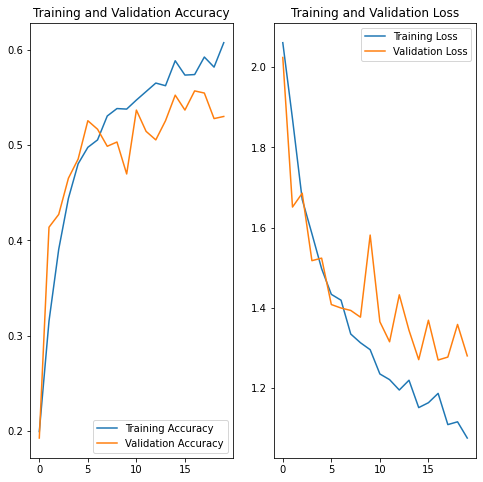

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.

import glob

train_image_names = glob.glob('/content/gdrive/MyDrive/CNN/Assignment/Data/Train/*/*.jpg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

Total number of training images:  2239


In [25]:
# train_df: a dataframe with 2 field: Filename, ClassId
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate class_names field
train_df['class_names'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()

,Filename,class_names
0,ISIC_0024706.jpg,vascular lesion
1,ISIC_0025677.jpg,vascular lesion
2,ISIC_0025596.jpg,vascular lesion
3,ISIC_0024867.jpg,vascular lesion
4,ISIC_0025249.jpg,vascular lesion


In [26]:
class_id_distribution = train_df['class_names'].value_counts()
class_id_distribution.head(10)

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: class_names, dtype: int64

<BarContainer object of 9 artists>

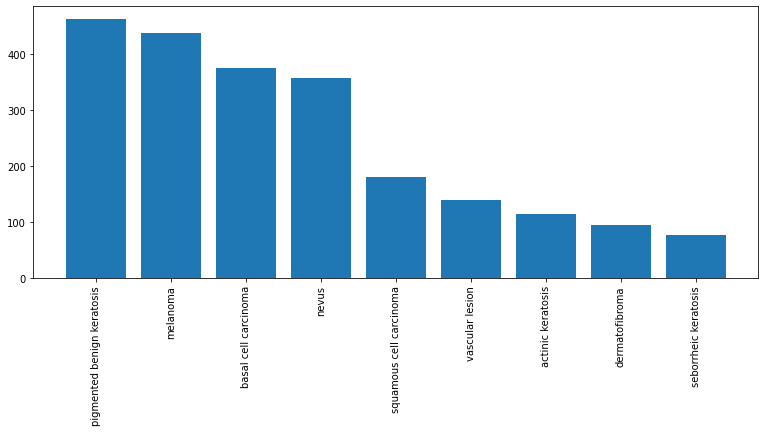

In [27]:
plt.figure(figsize=(13,5))
plt.xticks(np.arange(43), rotation='vertical')
plt.bar(class_id_distribution.index, class_id_distribution.values)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Findings**
- seborrheic keratosis has the least number of samples
- pigmented benign keratosis and melanoma classes dominates the data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset='/content/gdrive/MyDrive/CNN/Assignment/Data/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB52040D460>: 100%|██████████| 500/500 [00:25<00:00, 19.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB52047FB50>: 100%|██████████| 500/500 [00:27<00:00, 18.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB5203CBC10>: 100%|██████████| 500/500 [00:22<00:00, 22.45 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB5232BC280>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FB5A0099FD0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB5203906D0>: 100%|██████████| 500/500 [00:20<00:00, 24.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB520438580>: 100%|██████████| 500/500 [00:48<00:00, 10.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB5BBD26FD0>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB52043DEB0>: 100%|██████████| 500/500 [00:22<00:00, 22.38 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
'''import fnmatch
import os

matches = []
for root, dirnames, filenames in os.walk(data_dir_train):
    for filename in fnmatch.filter(filenames, '*','output', '*.jpg'):
        matches.append(os.path.join(root, filename))'''

from pathlib import Path

for path in Path(data_dir_train).rglob('output'):
    print(path.name)

output
output
output
output
output
output
output
output
output


In [32]:
#path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

path_list = [x for x in glob.glob('/content/gdrive/MyDrive/CNN/Assignment/Data/Train/*/output/*.jpg', recursive=True)]#(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output/vascular lesion_original_ISIC_0027672.jpg_ec9dd47a-8cec-4437-9a1b-167ddb1b8357.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output/vascular lesion_original_ISIC_0026693.jpg_f665e96c-6564-4f34-b53d-84f186ffbee2.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_898cbbb6-e77f-44af-9981-2b1462fdbaea.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_ab17d8cd-5429-490b-8fe6-e2a1ac4d3f65.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output/vascular lesion_original_ISIC_0024706.jpg_8468928d-34e9-431e-b5f9-f83ace12b45b.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment/Data/Train/vascular lesion/output/vascular lesion_original_ISIC_0030770.jpg_5ec31b2b-526a-4592-9d4e-8968e91b3a14.jpg',
 '/content/gdrive/MyDrive/CNN/Assignment

In [33]:
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob('/content/gdrive/MyDrive/CNN/Assignment/Data/Train/*/output/*.jpg', recursive=True)]# glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [34]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = train_df.append(df2)

In [36]:
new_df['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
pigmented benign keratosis    500
dermatofibroma                500
actinic keratosis             500
basal cell carcinoma          500
nevus                         500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
data_dir_train= '/content/gdrive/MyDrive/CNN/Assignment/Data/Train/' #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here
### Your code goes here
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.27009806 0.99117655


In [41]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(10, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)       

#### **Todo:**  Train your model

In [44]:
#epochs = 30
## Your code goes here, use 50 epochs.
#history = # your model fit code

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 243ms/step - loss: 1.9704 - accuracy: 0.2600 - val_loss: 1.6273 - val_accuracy: 0.3950
Epoch 2/30
169/169 [==============================] - 34s 195ms/step - loss: 1.4906 - accuracy: 0.4343 - val_loss: 1.4381 - val_accuracy: 0.4707
Epoch 3/30
169/169 [==============================] - 36s 205ms/step - loss: 1.3527 - accuracy: 0.4915 - val_loss: 1.3713 - val_accuracy: 0.4885
Epoch 4/30
169/169 [==============================] - 43s 249ms/step - loss: 1.2524 - accuracy: 0.5302 - val_loss: 1.2471 - val_accuracy: 0.5457
Epoch 5/30
169/169 [==============================] - 36s 205ms/step - loss: 1.1427 - accuracy: 0.5796 - val_loss: 1.2509 - val_accuracy: 0.5419
Epoch 6/30
169/169 [==============================] - 36s 204ms/step - loss: 1.0196 - accuracy: 0.6185 - val_loss: 1.0524 - val_accuracy: 0.6117
Epoch 7/30
169/169 [==============================] - 38s 217ms/step - loss: 0.8683 - accuracy: 0.6910 - val_loss: 1.0969 - val_ac

#### **Todo:**  Visualize the model results

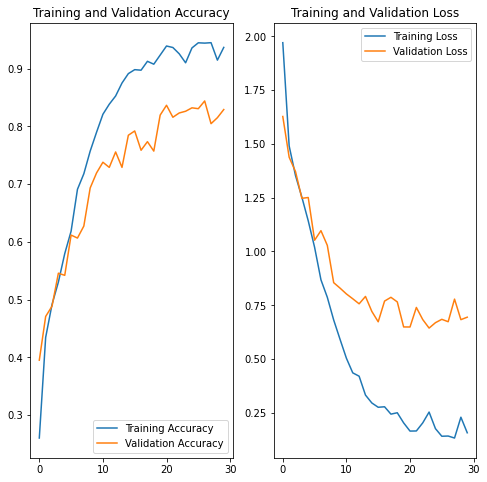

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [46]:
# After Class balance the overall accuracy has been imporved.